In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
import json
import plotly.graph_objects as go

In [4]:
#Constants

R = 8.314
P = 1 #atm

A_but = 9.9614
B_but = 2664.0939
C_but = -104.881
A_h2O = 11.9647
B_h2O = 3984.9273
C_h2O = -39.734

g12_g22 = 1034.3
g21_g11 = 10098.50
aij = 0.4118

In [5]:
#Functions 

def molfrac_vapor(T, x):
    x_but = 1-x
    x_h2O = x

    tau_12 = g12_g22 / (R * T)
    tau_21 = g21_g11 / (R * T)

    G_12 = np.exp(-aij * tau_12)
    G_21 = np.exp(-aij * tau_21)

    gamma_but = np.exp(x_h2O**2 * (tau_21 * (G_21 / (x_but + x_h2O * G_21))**2 + (tau_12 * G_12) / (x_h2O + x_but * G_12)**2))
    gamma_h2O = np.exp(x_but**2 * (tau_12 * (G_12 / (x_h2O + x_but * G_12))**2 + (tau_21 * G_21) / (x_but + x_h2O * G_21)**2))
    
    Psat_but = np.exp(A_but - B_but / (T + C_but))
    Psat_h2O = np.exp(A_h2O - B_h2O / (T + C_h2O))
    
    y_but = gamma_but * x_but * Psat_but / P
    y_h2O = gamma_h2O * x_h2O * Psat_h2O / P
    
    sum_y = y_but + y_h2O
    
    return sum_y - 1, y_but, y_h2O

def wrapper(T, x):
    sum_y, _, _ = molfrac_vapor(T, x)
    return sum_y

In [6]:
# Calculate the solutions for each x value
#x_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
x_values = np.arange(0, 1, 0.001)
solutions = {}  # Dictionary to store solutions
initial_guess = 373  # Kelvin

for i, x in enumerate(x_values):
    sol, = fsolve(wrapper, initial_guess, args=x)
    _, y_but, y_h2O = molfrac_vapor(sol, x)
    
    # Create a dictionary for this x value and store it in the solutions dictionary
    solutions[x] = {
        'Tsol': sol,
        'y_but': y_but,
        'y_h2O': y_h2O
    }

#Pretty-print the solutions dictionary
#print(json.dumps(solutions, indent=4))

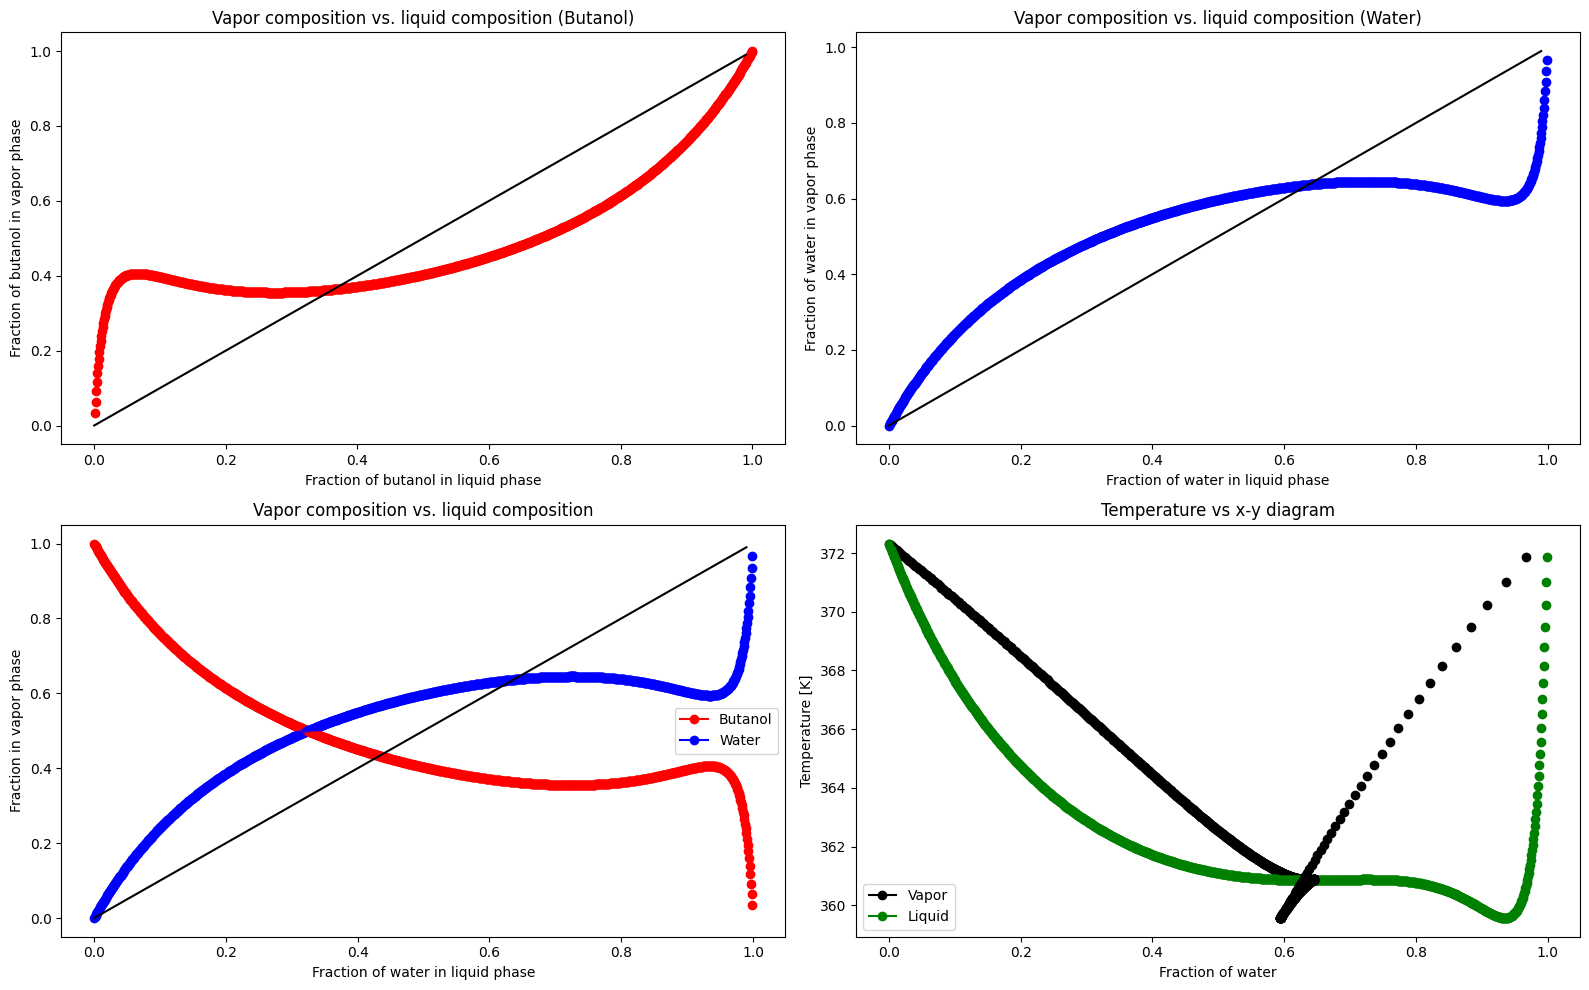

In [10]:
# Create 2x2 subplots
fig, axs = plt.subplots(2, 2, figsize=(16, 10))

# Prepare data
x_lin = np.arange(0, 1, 0.01)
y_lin = np.arange(0, 1, 0.01)

# Plot data
for x, sol_dict in solutions.items():
    axs[0, 0].plot(1-x, sol_dict['y_but'], marker='o', color='red')
    axs[0, 1].plot(x, sol_dict['y_h2O'], marker='o', color='blue')
    
    axs[1, 0].plot(x, sol_dict['y_but'], marker='o', color='red')
    axs[1, 0].plot(x, sol_dict['y_h2O'], marker='o', color='blue')


    axs[1, 1].plot(sol_dict['y_h2O'], sol_dict['Tsol'], marker='o', color='black')
    axs[1, 1].plot(x, sol_dict['Tsol'], marker='o', color='green')
    

# Add diagonal lines
for ax in [axs[0, 0], axs[0, 1], axs[1, 0]]:
    ax.plot(x_lin, y_lin, color='black')

# Add titles and labels
axs[0, 0].set_title('Vapor composition vs. liquid composition (Butanol)')
axs[0, 0].set_xlabel('Fraction of butanol in liquid phase')
axs[0, 0].set_ylabel('Fraction of butanol in vapor phase')

axs[0, 1].set_title('Vapor composition vs. liquid composition (Water)')
axs[0, 1].set_xlabel('Fraction of water in liquid phase')
axs[0, 1].set_ylabel('Fraction of water in vapor phase')

axs[1, 0].set_title('Vapor composition vs. liquid composition')
axs[1, 0].set_xlabel('Fraction of water in liquid phase')
axs[1, 0].set_ylabel('Fraction in vapor phase')
axs[1, 0].legend(['Butanol','Water'])

axs[1, 1].set_title('Temperature vs x-y diagram')
axs[1, 1].set_xlabel('Fraction of water')
axs[1, 1].set_ylabel('Temperature [K]')
axs[1, 1].legend(['Vapor', 'Liquid'])

# Show the plot
plt.tight_layout()
plt.show()
